In [3]:
"""
cut_list.ipynb
---------------------------------------------
Mixed-Integer Linear Programming (MILP) formulation for
minimum-cost rectangular sheet cutting with:

    • 2D placement (x,y) coordinates and variable board types
    • per-item thickness compatibility (3D extension, no cuts along thickness)
    • optional in-plane rotation
    • kerf / gap handling
    • multi-quantity BOM expansion
    • full non-guillotine support (no enforced cut sequence)

Each item (BOM part) is assigned to one purchased board of a matching
thickness.  Boards are selected from a finite catalog of stock types, each
with cost, width, length, and thickness.  The model minimizes total purchase
cost subject to non-overlap and inside-board constraints.

Mathematical lineage and references
---------------------------------------------
This model synthesizes elements from the classical 2D cutting-stock and
facility-layout MILP literature:

1. Beasley, J.E. (1985)
   “An Exact Two-Dimensional Non-Guillotine Cutting Tree Search Procedure.”
   *Operations Research*, 33(1), 49-64.
   DOI: 10.1287/opre.33.1.49
   → Introduced non-guillotine 2D cutting and disjunctive non-overlap logic.

2. Mlefter, R.D. & Gau, K.Y. (1996)
   “The Facility Layout Problem: Recent and Emerging Trends and Perspectives.”
   *Journal of Manufacturing Systems*, 15(5), 351-366.
   → Canonical 4-way disjunction (left/right/above/below) for rectangle non-overlap.

3. Martlefto, S. & Vigo, D. (1998)
   “Exact Solution of the Two-Dimensional Finite Bin Packing Problem.”
   *Management Science*, 44(3), 388-399.
   → Binary assignment u[i,k] with finite discrete bins (our board slots).

4. Pisinger, D. & Sigurd, M. (2007)
   “The Two-Dimensional Bin Packing Problem with Variable Bin Sizes.”
   *European Journal of Operational Research*, 183(2), 962-974.
   → Variable board types and purchase cost selection via z[k,j] binaries.

5. Castillo, I. & Westerlund, T. (2005)
   “An Exact MILP Model for the Unequal-Area Facility Layout Problem.”
   → Provided the big-M linearization structure used for the spatial disjunctions.

6. Cui, H., Bennleft, J.A., Dowsland, K.A., & Dowsland, W.B. (2015)
   “A Review of Geometric Models for Cutting and Packing Problems.”
   *European Journal of Operational Research*, 241(3), 501-518.
   → Survey establishing current best-practice MILPs for non-guillotine cutting.

7. Crainic, T.G., Perboli, G., Tadei, R., & Vigo, D. (2008)
   “A Three-Dimensional Bin Packing Formulation for Multidimensional Logistics Problems.”
   *European Journal of Operational Research*, 184(3), 970-990.
   → Source for the thickness (third-dimension) compatibility logic used here.

8. Dyckhoff, H. (1990); Wäscher, G., Haußner, H., & Schumann, H. (2007)
   Typologies of Cutting and Packing Problems.
   → Classify this formulation as a 2D/3D Open Dimension Problem (2D-ODP / 3D-ODP)
     with discrete bin types and additive cost objective.

Implementation summary
---------------------------------------------
• z[k,j] ∈ {0,1}  → slot k uses stock type j
• u[i,k] ∈ {0,1}  → item i assigned to slot k
• r[i] ∈ {0,1}    → rotation 90° in-plane
• (x[i,k], y[i,k]) continuous lower-left corner
• Non-overlap enforced by 4 disjunction binaries (ℓ, r, a, b)
• Optional kerf inflates in-plane width/height
• Quantities handled by expanding each BOM row into qty copies
• Visualization per purchased board with labeled parts

Author: Emily Fairfield (2025)
Inspiration and formulation assembled with assistance from GPT-5,
integrating canonical models from operations research literature.
"""

'\ncut_list.ipynb\n---------------------------------------------\nMixed-Integer Linear Programming (MILP) formulation for\nminimum-cost rectangular sheet cutting with:\n\n    • 2D placement (x,y) coordinates and variable board types\n    • per-item thickness compatibility (3D extension, no cuts along thickness)\n    • optional in-plane rotation\n    • kerf / gap handling\n    • multi-quantity BOM expansion\n    • full non-guillotine support (no enforced cut sequence)\n\nEach item (BOM part) is assigned to one purchased board of a matching\nthickness.  Boards are selected from a finite catalog of stock types, each\nwith cost, width, length, and thickness.  The model minimizes total purchase\ncost subject to non-overlap and inside-board constraints.\n\nMathematical lineage and references\n---------------------------------------------\nThis model synthesizes elements from the classical 2D cutting-stock and\nfacility-layout MILP literature:\n\n1. Beasley, J.E. (1985)\n   “An Exact Two-Dime

{'id': 'P1', 'a': '5', 'b': '4', 't': '0.75', 'rot': '1', 'qty': '2'}
{'id': 'P2', 'a': '5', 'b': '5', 't': '0.75', 'rot': '1', 'qty': '2'}
{'id': 'P3', 'a': '10', 'b': '1', 't': '0.75', 'rot': '1', 'qty': '2'}
{'id': 'P4', 'a': '9', 'b': '5', 't': '0.75', 'rot': '1', 'qty': '2'}
{'id': 'P5', 'a': '10', 'b': '5', 't': '0.75', 'rot': '1', 'qty': '2'}
{'id': 'T1', 'L': '15', 'W': '10', 'T': '0.75', 'cost': '30'}
{'id': 'T2', 'L': '15', 'W': '15', 'T': '0.75', 'cost': '40'}
{'id': 'T3', 'L': '15', 'W': '10', 'T': '0.5', 'cost': '20'}
Loaded BOM items (expanded by quantity): 10
Loaded stock types: 3
Status: Optimal
Min cost: 60.0

Boards to buy (by type):
  T1: 2

Cut list (first 10 rows):
{'item_id': 'P1#1', 'base_id': 'P1', 'slot': 1, 'stock_type': 'T1', 'stock_WxLxT': (10.0, 15.0, 0.75), 'x': 1.0, 'y': 5.0, 'width': 4.0, 'height': 5.0, 'thickness': 0.75, 'rotated': False}
{'item_id': 'P1#2', 'base_id': 'P1', 'slot': 0, 'stock_type': 'T1', 'stock_WxLxT': (10.0, 15.0, 0.75), 'x': 0.0, 'y'

C:\Users\russe\AppData\Local\Temp\ipykernel_26808\2012000084.py:268: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  tab20 = plt.cm.get_cmap("tab20").colors


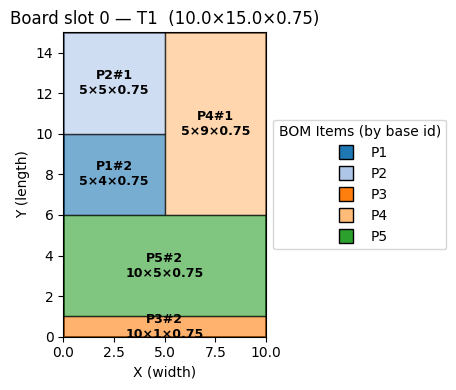

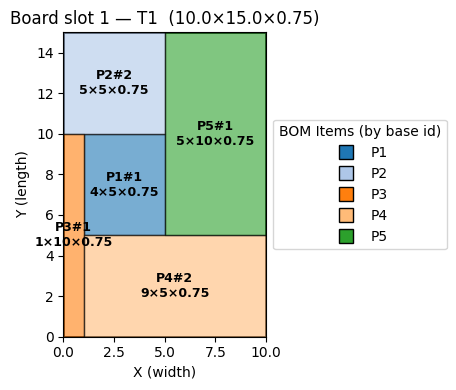

In [4]:
import os, json, csv
from itertools import combinations
import pulp as pl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# ============================================================
# ----------- CONFIG: set your input file paths --------------
# ============================================================
#BOM should include:
#"id": unique identifier of your choice
#"a": length of the item
#"b": width of the item
#"t": thickness of the item
#"rot": 1 if the item can be rotated, 0 otherwise (if grain direction must match the orientation of the stock sheet)
#"qty": quantity of the item needed

#Stock should include:
#"id": unique identifier of your choice
#"L": length of the stock sheet
#"W": width of the stock sheet
#"T": thickness of the stock sheet
#"cost": cost of the stock sheet

BOM_PATH   = "data/bom.csv"
STOCK_PATH = "data/stock.csv" 

# Kerf (set to saw kerf or desired gap)
KERF = 0.0

# ============================================================
# -------------------- Data loaders --------------------------
# ============================================================
def _load_table(path, required_keys):
    if path is None or not os.path.exists(path):
        raise ValueError(f"File not found: {path}")
    ext = os.path.splitext(path)[1].lower()
    rows = []
    if ext == ".json":
        with open(path, "r", encoding="utf-8") as f:
            rows = json.load(f)
    elif ext == ".csv":
        with open(path, "r", newline="", encoding="utf-8-sig") as f:
            rdr = csv.DictReader(f)
            for r in rdr:
                rows.append({k: r.get(k) for k in rdr.fieldnames})
    else:
        raise ValueError(f"Unsupported file type: {ext}")

    # normalize types and check keys
    normed = []
    for r in rows:
        print(r)
        if not all(k in r for k in required_keys):
            missing = [k for k in required_keys if k not in r]
            raise ValueError(f"Missing keys {missing} in row: {r}")

        # cast types based on keys
        out = dict(r)
        for k in ["a","b","t","L","W","T","cost"]:
            if k in out and out[k] is not None:
                out[k] = float(out[k])
        for k in ["rot","qty"]:
            if k in out and out[k] is not None:
                out[k] = int(float(out[k]))
        normed.append(out)
    return normed

def load_bom(path):
    rows = _load_table(path, required_keys=["id","a","b","t","rot","qty"])
    # Expand by quantity: one instance per part needed
    expanded = []
    for r in rows:
        base = {k: r[k] for k in ["id","a","b","t","rot","qty"]}
        q = int(base["qty"])
        for qn in range(1, q+1):
            part = {
                "id": f'{base["id"]}#{qn}',
                "base_id": base["id"],  # for coloring all parts of same type the same color
                "a": base["a"],
                "b": base["b"],
                "t": base["t"],
                "rot": base["rot"],
            }
            expanded.append(part)
    return expanded

def load_stock(path):
    rows = _load_table(path, required_keys=["id","L","W","T","cost"])
    return rows

# ============================================================
# ----------------- Build & solve MILP -----------------------
# ============================================================
def solve_cutlist(bom_parts, stock_types, kerf=0.0):
    # Indices & arrays
    items = bom_parts
    types = stock_types

    I = range(len(items))
    J = range(len(types))
    # Board slots upper bound: one per item
    Kslots = range(len(items))

    id_item = [item["id"] for item in items]
    base_id = [item.get("base_id", item["id"]) for item in items]
    a = [item["a"] for item in items]
    b = [item["b"] for item in items]
    t_item = [item["t"] for item in items]
    rot_allow = [item["rot"] for item in items]

    id_type = [t["id"] for t in types]
    L = [t["L"] for t in types]
    W = [t["W"] for t in types]
    T_stock = [t["T"] for t in types]
    COST = [t["cost"] for t in types]

    Mx, My = max(W), max(L)

    # Compatibility by thickness
    compat_j = {i: [j for j in J if T_stock[j] == t_item[i]] for i in I}

    # Model
    m = pl.LpProblem("CutList_MILP_Thickness_Qty", pl.LpMinimize)

    # Vars
    z = pl.LpVariable.dicts("z", (Kslots, J), 0, 1, cat="Binary")
    u = pl.LpVariable.dicts("u", (I, Kslots), 0, 1, cat="Binary")
    r = [pl.LpVariable(f"r_{i}", 0, rot_allow[i], cat="Binary") for i in I]
    x = pl.LpVariable.dicts("x", (I, Kslots), 0, None, cat="Continuous")
    y = pl.LpVariable.dicts("y", (I, Kslots), 0, None, cat="Continuous")

    pair_idx = list(combinations(I, 2))
    left = pl.LpVariable.dicts("left", (pair_idx, Kslots), 0, 1, cat="Binary")
    right = pl.LpVariable.dicts("right", (pair_idx, Kslots), 0, 1, cat="Binary")
    above = pl.LpVariable.dicts("above", (pair_idx, Kslots), 0, 1, cat="Binary")
    below = pl.LpVariable.dicts("below", (pair_idx, Kslots), 0, 1, cat="Binary")

    # Helpers (linear/affine)
    def w_i(i):  # width
        return (1 - r[i]) * b[i] + r[i] * a[i] + kerf
    def h_i(i):  # height
        return (1 - r[i]) * a[i] + r[i] * b[i] + kerf
    def Wk(k):
        return pl.lpSum(W[j] * z[k][j] for j in J)
    def Lk(k):
        return pl.lpSum(L[j] * z[k][j] for j in J)

    # Objective
    m += pl.lpSum(COST[j] * z[k][j] for k in Kslots for j in J)

    # Constraints
    # 1) At most one type per slot (unused allowed)
    for k in Kslots:
        m += pl.lpSum(z[k][j] for j in J) <= 1, f"type_cap[{k}]"

    # 2) Each item assigned to exactly one slot
    for i in I:
        m += pl.lpSum(u[i][k] for k in Kslots) == 1, f"assign_once[{i}]"

    # 3) Thickness compatibility + slot activeness
    for i in I:
        allowed = compat_j[i]
        for k in Kslots:
            if allowed:
                m += u[i][k] <= pl.lpSum(z[k][j] for j in allowed), f"thick_link[{i},{k}]"
            else:
                m += u[i][k] == 0, f"no_compat[{i},{k}]"

    # 4) Inside-board bounds
    for i in I:
        for k in Kslots:
            m += x[i][k] <= Wk(k) - w_i(i) + Mx * (1 - u[i][k]), f"in_x_hi[{i},{k}]"
            m += y[i][k] <= Lk(k) - h_i(i) + My * (1 - u[i][k]), f"in_y_hi[{i},{k}]"

    # 5) Non-overlap disjunctions for co-assigned pairs
    for (i, ip) in pair_idx:
        for k in Kslots:
            m += (
                left[(i, ip)][k] + right[(i, ip)][k] + above[(i, ip)][k] + below[(i, ip)][k]
                >= u[i][k] + u[ip][k] - 1
            ), f"disj_activate[{i},{ip},{k}]"
            m += x[i][k] + w_i(i)   <= x[ip][k] + Mx * (1 - left[(i, ip)][k]), f"left[{i},{ip},{k}]"
            m += x[ip][k] + w_i(ip) <= x[i][k] + Mx * (1 - right[(i, ip)][k]), f"right[{i},{ip},{k}]"
            m += y[i][k] + h_i(i)   <= y[ip][k] + My * (1 - above[(i, ip)][k]), f"above[{i},{ip},{k}]"
            m += y[ip][k] + h_i(ip) <= y[i][k] + My * (1 - below[(i, ip)][k]), f"below[{i},{ip},{k}]"

    # 6) Optional symmetry breaking (helps performance)
    for k in range(len(items) - 1):
        m += pl.lpSum(z[k + 1][j] for j in J) <= pl.lpSum(z[k][j] for j in J), f"sym_break[{k}]"

    # Solve
    m.solve(pl.PULP_CBC_CMD(msg=True))
    status = pl.LpStatus[m.status]
    cost   = pl.value(m.objective)
    print("Status:", status)
    print("Min cost:", cost)

    # Extract solution
    # Slot -> selected type
    slot_type = {}
    for k in Kslots:
        for j in J:
            if pl.value(z[k][j]) > 0.5:
                slot_type[k] = j
                break

    # Purchase counts
    purchase = {}
    for k, j in slot_type.items():
        purchase[id_type[j]] = purchase.get(id_type[j], 0) + 1

    # Cut list rows
    cutlist = []
    for i in I:
        # chosen slot
        k = max(Kslots, key=lambda kk: pl.value(u[i][kk]))
        if pl.value(u[i][k]) < 0.5:
            continue
        j = slot_type.get(k, None)
        if j is None:
            continue

        xi = pl.value(x[i][k])
        yi = pl.value(y[i][k])
        ri = round(pl.value(r[i]))
        wi = (1 - ri) * b[i] + ri * a[i] + KERF
        hi = (1 - ri) * a[i] + ri * b[i] + KERF

        cutlist.append({
            "item_id": id_item[i],
            "base_id": base_id[i],          # color grouping
            "slot": k,
            "stock_type": id_type[j],
            "stock_WxLxT": (W[j], L[j], T_stock[j]),
            "x": xi, "y": yi,
            "width": wi, "height": hi,
            "thickness": t_item[i],
            "rotated": bool(ri),
        })

    return {
        "status": status,
        "cost": cost,
        "purchase": purchase,
        "cutlist": cutlist,
        "slot_type": slot_type,
        "types_meta": {"id_type": id_type, "W": W, "L": L, "T_stock": T_stock},
    }

# ============================================================
# --------------------- Visualization ------------------------
# ============================================================
def plot_per_board(solution):
    slot_type = solution["slot_type"]
    types_meta = solution["types_meta"]
    id_type, W, L, T_stock = types_meta["id_type"], types_meta["W"], types_meta["L"], types_meta["T_stock"]

    cutlist = solution["cutlist"]
    # Group items by slot
    items_by_slot = {}
    for row in cutlist:
        items_by_slot.setdefault(row["slot"], []).append(row)

    # Stable colors by base_id
    base_ids = sorted({row["base_id"] for row in cutlist})
    tab20 = plt.cm.get_cmap("tab20").colors
    palette = list(tab20)
    if len(base_ids) > len(palette):
        # extend with HSV if needed
        palette += [plt.cm.hsv(i / float(len(base_ids))) for i in range(len(base_ids))]
    color_map = {bid: palette[i % len(palette)] for i, bid in enumerate(base_ids)}

    for k, j in slot_type.items():
        board_w, board_l, board_t = W[j], L[j], T_stock[j]

        fig, ax = plt.subplots(figsize=(max(6, board_w/24), max(4, board_l/24)))
        ax.set_title(f"Board slot {k} — {id_type[j]}  ({board_w}×{board_l}×{board_t})")
        ax.set_xlim(0, board_w)
        ax.set_ylim(0, board_l)
        ax.set_aspect('equal', adjustable='box')
        ax.set_xlabel("X (width)")
        ax.set_ylabel("Y (length)")

        # Board outline
        ax.add_patch(Rectangle((0, 0), board_w, board_l, fill=False, lw=2, ec='black'))

        legend_handles = {}
        for row in items_by_slot.get(k, []):
            xi, yi = row["x"], row["y"]
            wi, hi = row["width"], row["height"]
            iid = row["item_id"]
            bid = row["base_id"]
            col = color_map[bid]

            rect = Rectangle((xi, yi), wi, hi, facecolor=col, alpha=0.6, edgecolor='k')
            ax.add_patch(rect)

            # label with item_id and dims
            ax.text(
                xi + wi/2, yi + hi/2,
                f'{iid}\n{wi:.0f}×{hi:.0f}×{row["thickness"]}',
                ha='center', va='center', fontsize=9, weight='bold'
            )

            if bid not in legend_handles:
                legend_handles[bid] = Line2D([0],[0], marker='s', color='w',
                                             markerfacecolor=col, markeredgecolor='k',
                                             markersize=10, label=bid)

        if legend_handles:
            ax.legend(handles=list(legend_handles.values()), title="BOM Items (by base id)", loc='center left', bbox_to_anchor=(1, 0.5), frameon=True)

        plt.tight_layout()
        # Uncomment to save:
        # plt.savefig(f"cut_board_{k}_{id_type[j]}_{board_t}.png", dpi=150)
        plt.show()

# ============================================================
# --------------------------- Main ---------------------------
# ============================================================
def main():
    bom_parts  = load_bom(BOM_PATH)
    stock_types= load_stock(STOCK_PATH)

    print("Loaded BOM items (expanded by quantity):", len(bom_parts))
    print("Loaded stock types:", len(stock_types))

    result = solve_cutlist(bom_parts, stock_types, kerf=KERF)

    print("\nBoards to buy (by type):")
    for t, cnt in result["purchase"].items():
        print(f"  {t}: {cnt}")

    print("\nCut list (first 10 rows):")
    for row in result["cutlist"][:10]:
        print(row)
    if len(result["cutlist"]) > 10:
        print(f"... ({len(result['cutlist'])-10} more)")

    plot_per_board(result)

if __name__ == "__main__":
    main()